In [45]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
from typing import TypedDict,Literal
from pydantic import BaseModel , Field

In [46]:
load_dotenv()
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash-lite",
    max_tokens=250
)

In [47]:
class sentiment_schema(BaseModel):
    sentiment : Literal['positive','negative'] = Field(description="Sentiment of the review provided")
    
class dianostic_schema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [48]:
sentiment_model = model.with_structured_output(sentiment_schema)
dianostic_model = model.with_structured_output(dianostic_schema)

In [49]:
class reviewState(TypedDict):
    review:str
    sentiment:Literal['positive','negative']
    diagnosis:dict
    reply:str

In [50]:
def Sentiment_analyser(state:reviewState):
    prompt = f'For the following review find out the sentiment \n {state["review"]}'
    sentiment = sentiment_model.invoke(prompt).sentiment
    return {'sentiment':sentiment}

In [51]:
def sentiment_checker(state:reviewState)->Literal['Positive_Feedback','Run_Diagnosis']:
    if state['sentiment']=='positive':
        return 'Positive_Feedback'
    elif state['sentiment']=='negative':
        return 'Run_Diagnosis'
    else:
        raise ValueError("Unidentified sentiment")

In [52]:
def positive_reposnse(state:reviewState):
    prompt = f"""Write a warm thank-you message in response to this review:\n\n
    "{state['review']}"\n\n
    Also, kindly ask the user to leave feedback on our website."""
    reply = model.invoke(prompt).content
    return {'reply':reply}

In [53]:
def Sentiment_Diagnosis(state:reviewState):
    prompt = f"""Diagnose this negative review:\n\n
    {state['review']}\n""
    Return issue_type, tone, and urgency."""
    diagnosis = dianostic_model.invoke(prompt)
    return {'diagnosis':diagnosis.model_dump()}


def neagtive_reposnse(state:reviewState):
    diagnosis = state['diagnosis']
    prompt = f"""
    You are a support assistant.
    The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', 
    and marked urgency as '{diagnosis['urgency']}'.

    Original review: {state['review']}

    Write an empathetic, helpful resolution message.
    Also, kindly ask the user to leave feedback on our website.
    """
    
    reply = model.invoke(prompt)
    return {'reply':reply}

In [54]:
graph =  StateGraph(reviewState)

graph.add_node('Analyse_Sentiment',Sentiment_analyser)
graph.add_node('Run_Diagnosis',Sentiment_Diagnosis)
graph.add_node('Positive_Feedback',positive_reposnse)
graph.add_node('Negative_Feedback',neagtive_reposnse)

graph.add_edge(START,'Analyse_Sentiment')
graph.add_conditional_edges('Analyse_Sentiment',sentiment_checker)
graph.add_edge('Run_Diagnosis','Negative_Feedback')
graph.add_edge('Positive_Feedback',END)
graph.add_edge('Negative_Feedback',END)

workflow = graph.compile()

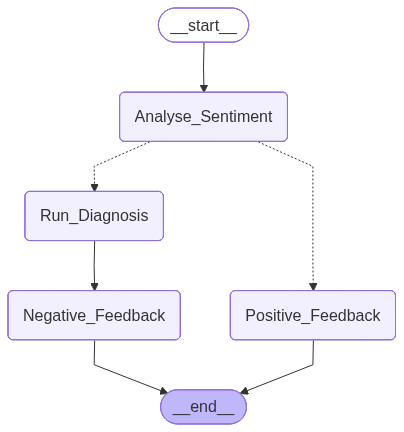

In [31]:
workflow

In [42]:

intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
final_state=workflow.invoke(intial_state)

In [43]:
final_state

{'review': 'I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.',
 'sentiment': 'negative',
 'diagnosis': {'issue_type': 'Bug', 'tone': 'frustrated', 'urgency': 'high'},
 'reply': AIMessage(content='Subject: Regarding your Login Issue - We\'re on it!\n\nHi there,\n\nI\'m so sorry to hear you\'re experiencing this frustrating login issue! I understand how annoying it is when you can\'t access the app, especially when it\'s a basic function like logging in. I know you\'ve already tried reinstalling, and I appreciate you taking that step.\n\nWe\'re aware of this bug and our team is working hard to resolve it as quickly as possible. We\'re currently investigating the cause of the freezing on the authentication screen and are looking into potential fixes right now.\n\nIn the meantime, I don\'t have a guaranteed sol

In [44]:
from IPython.display import Image
print(workflow.get_graph().draw_ascii())

                    +-----------+                      
                    | __start__ |                      
                    +-----------+                      
                          *                            
                          *                            
                          *                            
                +-------------------+                  
                | Analyse_Sentiment |                  
                +-------------------+                  
                  ..             ...                   
               ...                  ...                
             ..                        ..              
  +---------------+                      ..            
  | Run_Diagnosis |                       .            
  +---------------+                       .            
          *                               .            
          *                               .            
          *                               .     